# 情感分析及数据集
:label:`sec_sentiment`

随着在线社交媒体和评论平台的快速发展，大量评论的数据被记录下来。这些数据具有支持决策过程的巨大潜力。
*情感分析*（sentiment analysis）研究人们在文本中
（如产品评论、博客评论和论坛讨论等）“隐藏”的情绪。
它在广泛应用于政治（如公众对政策的情绪分析）、
金融（如市场情绪分析）和营销（如产品研究和品牌管理）等领域。

由于情感可以被分类为离散的极性或尺度（例如，积极的和消极的），我们可以将情感分析看作一项文本分类任务，它将可变长度的文本序列转换为固定长度的文本类别。在本章中，我们将使用斯坦福大学的[大型电影评论数据集（large movie review dataset）](https://ai.stanford.edu/~amaas/data/sentiment/)进行情感分析。它由一个训练集和一个测试集组成，其中包含从IMDb下载的25000个电影评论。在这两个数据集中，“积极”和“消极”标签的数量相同，表示不同的情感极性。


In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##  读取数据集

首先，下载并提取路径`../data/aclImdb`中的IMDb评论数据集。


In [2]:
#@save
d2l.DATA_HUB['aclImdb'] = (
    'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
    '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

接下来，读取训练和测试数据集。每个样本都是一个评论及其标签：1表示“积极”，0表示“消极”。


In [3]:
#@save
def read_imdb(data_dir, is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('训练集数目：', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('标签：', y, 'review:', x[0:60])

训练集数目： 25000
标签： 1 review: Henry Hathaway was daring, as well as enthusiastic, for his 
标签： 1 review: An unassuming, subtle and lean film, "The Man in the White S
标签： 1 review: Eddie Murphy really made me laugh my ass off on this HBO sta


## 预处理数据集

将每个单词作为一个词元，过滤掉出现不到5次的单词，我们从训练数据集中创建一个词表。


In [4]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

在词元化之后，让我们绘制评论词元长度的直方图。


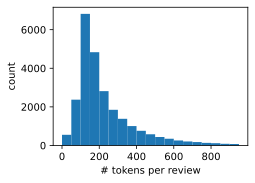

In [5]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过截断和填充将每个评论的长度设置为500。这类似于 :numref:`sec_machine_translation`中对机器翻译数据集的预处理步骤。


In [6]:
num_steps = 500  # 序列长度
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## 创建数据迭代器

现在我们可以创建数据迭代器了。在每次迭代中，都会返回一小批量样本。


In [7]:
train_iter = d2l.load_array((train_features,
    torch.tensor(train_data[1])), 64)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('小批量数目：', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
小批量数目： 391


## 整合代码

最后，我们将上述步骤封装到`load_data_imdb`函数中。它返回训练和测试数据迭代器以及IMDb评论数据集的词表。


In [8]:
#@save
def load_data_imdb(batch_size, num_steps=500):
    """返回数据迭代器和IMDb评论数据集的词表"""
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

## 小结

* 情感分析研究人们在文本中的情感，这被认为是一个文本分类问题，它将可变长度的文本序列进行转换转换为固定长度的文本类别。
* 经过预处理后，我们可以使用词表将IMDb评论数据集加载到数据迭代器中。

## 练习

1. 我们可以修改本节中的哪些超参数来加速训练情感分析模型？
1. 请实现一个函数来将[Amazon reviews](https://snap.stanford.edu/data/web-Amazon.html)的数据集加载到数据迭代器中进行情感分析。


[Discussions](https://discuss.d2l.ai/t/5726)
